<a href="https://colab.research.google.com/github/leobertolazzi/aes-bert/blob/main/aes_distilbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated Essay Scoring with DistilBERT embeddings

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install --quiet transformers

     |████████████████████████████████| 5.8 MB 15.8 MB/s 
     |████████████████████████████████| 7.6 MB 58.5 MB/s 
     |████████████████████████████████| 182 kB 68.6 MB/s 


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import cohen_kappa_score as kappa
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import DistilBertTokenizer, DistilBertModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

In [ ]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataset

In [ ]:
# Original kaggle training set
kaggle_dataset  = pd.read_csv('...', sep='\t', encoding = "ISO-8859-1")

# Smaller training set used for this project
dataset = pd.DataFrame(
  {
    'essay_id' : kaggle_dataset['essay_id'],
    'essay_set' : kaggle_dataset['essay_set'],
    'essay' : kaggle_dataset['essay'],
    'rater1' : kaggle_dataset['rater1_domain1'],
    'rater2' : kaggle_dataset['rater2_domain1'],
    'score' : kaggle_dataset['domain1_score']
  }
)

In [ ]:
kaggle_dataset.head()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,NaN,7,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,NaN,10,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
dataset.head()

,essay_id,essay_set,essay,rater1,rater2,score
0,1,1,"Dear local newspaper, I think effects computer...",4,4,8
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,9
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,7
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,10
4,5,1,"Dear @LOCATION1, I know having computers has a...",4,4,8


In [ ]:
dataset.shape

(12976, 6)

## Add Scaled Scores to Dataset

In [ ]:
# Rescale target_score
scaler = StandardScaler()
scaled = []
for essay_set in range(1,9):
  score = dataset[dataset['essay_set'] == essay_set]['score'].to_frame()
  s = (scaler.fit_transform(score).reshape(-1))
  scaled = np.append(scaled, s)
    
dataset['scaled_score'] = scaled

In [ ]:
dataset.head()

,essay_id,essay_set,essay,rater1,rater2,score,scaled_score
0,1,1,"Dear local newspaper, I think effects computer...",4,4,8,-0.343483
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,9,0.306655
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,7,-0.993622
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,10,0.956794
4,5,1,"Dear @LOCATION1, I know having computers has a...",4,4,8,-0.343483


In [ ]:
y = dataset['scaled_score'].to_frame()

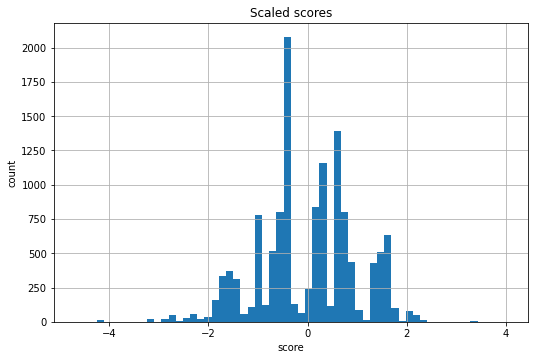

In [ ]:
plt.rcParams["figure.figsize"] = [8.50, 5.50]
y.hist(bins=60)
plt.title('Scaled scores')
plt.xlabel('score')
plt.ylabel('count')
plt.show()

## Essays Encoding

Essay are encoded following these steps:
1. the first 512 tokens of an essay are encoded in 768-d DistilBERT embeddings;
2. the embedding of an essay is the average embedding of all tokens embeddings

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-cased")
distilbert = DistilBertModel.from_pretrained("distilbert-base-cased").to(device)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def mean_encoding(essay_list, model, tokenizer):

  embeddings = []
  for essay in tqdm(essay_list):
    encoded_input = tokenizer(essay, padding=True, truncation=True, return_tensors='pt').to(device)
    with torch.no_grad():
      model_output = model(**encoded_input)
    tokens_embeddings = np.matrix(model_output[0].squeeze().cpu())
    embeddings.append(np.squeeze(np.asarray(tokens_embeddings.mean(0))))

  return np.matrix(embeddings)

In [ ]:
def get_id2emb(ids):

  id2emb = {}
  for n,id in enumerate(ids.to_list()):
    id2emb[id] = n
  
  return id2emb

In [ ]:
print('Encoding essay embeddings:')
essay_embeddings = mean_encoding(dataset['essay'], distilbert, tokenizer)
id2emb = get_id2emb(dataset['essay_id'])
print('Essay ids to emebeddings dictionary created.')

Encoding essay embeddings:


  0%|          | 0/12976 [00:00<?, ?it/s]

Essay ids to emebeddings dictionary created.


## Dataloaders

In [ ]:
def get_loader(df, id2emb, essay_embeddings, shuffle=True):

  # get embeddings from essay_id using id2emb dict
  embeddings = np.array([essay_embeddings[id2emb[id]] for id in df['essay_id']])

  # dataset and dataloader
  data = TensorDataset(torch.from_numpy(embeddings).float(), torch.from_numpy(np.array(df['scaled_score'])).float())
  loader = DataLoader(data, batch_size=128, shuffle=shuffle, num_workers=2)

  return loader

## MLP Regressor

In [ ]:
class MLPregressor(nn.Module):
  
  def __init__(self, input_size, hidden_size, output_size):
    super(MLPregressor, self).__init__()
    
    self.layers = nn.Sequential(
      nn.Linear(input_size, hidden_size),
      nn.Dropout(0.4),
      nn.ReLU(),
      nn.Linear(hidden_size, output_size)        
    )

  def forward(self, x):
    return self.layers(x)

In [ ]:
def training_step(model, cost_function, optimizer, train_loader):

  samples = 0.
  cumulative_loss = 0.

  model.train() 

  for step, (inputs, targets) in enumerate(train_loader):

    inputs = inputs.squeeze(dim=1).to(device)
    targets = targets.reshape(targets.shape[0],1).to(device)

    outputs = model(inputs)

    loss = cost_function(outputs, targets)

    loss.backward()  
  
    optimizer.step()  
 
    optimizer.zero_grad()

    samples += inputs.shape[0]
    cumulative_loss += loss.item()

  return cumulative_loss/samples


def test_step(model, cost_function, optimizer, test_loader):

  samples = 0.
  cumulative_loss = 0.
  preds = []

  model.eval() 

  with torch.no_grad():
    for step, (inputs, targets) in enumerate(test_loader):

      inputs = inputs.squeeze(dim=1).to(device)
      targets = targets.reshape(targets.shape[0],1).to(device)

      outputs = model(inputs)

      loss = cost_function(outputs, targets)

      samples += inputs.shape[0]
      cumulative_loss += loss.item()
      for out in outputs:
        preds.append(float(out))

  return cumulative_loss/samples, preds

## Training




In [ ]:
# hyper-parameters
input_size = 768
hidden_size = 200
output_size = 1 
epochs = 20
lr = 3e-4

# cross-validation folds
kf = KFold(n_splits=5, random_state=2022, shuffle=True)

# dicts with test_df and predictions for each model
test_df_dict = {}
preds_dict = {}

for n, (train, test) in enumerate(kf.split(dataset)):
  
  # train, validation, test split
  train_df = dataset.iloc[train]
  test_df = dataset.iloc[test]
  # dataloaders
  train_loader = get_loader(train_df, id2emb, essay_embeddings, shuffle=True)
  test_loader = get_loader(test_df, id2emb, essay_embeddings, shuffle=False)

  # model
  print('------------------------------------------------------------------')
  print(f"\t\t\tTraining model: {n+1}")
  print('------------------------------------------------------------------')
  model = MLPregressor(input_size, hidden_size, output_size).to(device)
  
  # loss and optimizer
  cost_function = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  # training
  train_loss, train_preds = test_step(model, cost_function, optimizer, train_loader)
  test_loss, test_preds = test_step(model, cost_function, optimizer, test_loader)
  print('Before training:\tLoss/train: {:.5f}\tLoss/test: {:.5f}'.format(train_loss, test_loss))

  for epoch in range(epochs):
    train_loss = training_step(model, cost_function, optimizer, train_loader)
    test_loss, test_preds = test_step(model, cost_function, optimizer, test_loader)
    print('Epoch: {:}\t\tLoss/train: {:.5f}\tLoss/test: {:.5f}'.format(epoch+1,train_loss, test_loss))

  train_loss, train_preds = test_step(model, cost_function, optimizer, train_loader)
  test_loss, test_preds = test_step(model, cost_function, optimizer, test_loader)
  print('After training:\t\tLoss/train: {:.5f}\tLoss/test: {:.5f}'.format(train_loss, test_loss))

  # store test_df and predictions
  test_df_dict[f"model_{n+1}"] = test_df
  preds_dict[f"model_{n+1}"] = test_preds

------------------------------------------------------------------
			Training model: 1
------------------------------------------------------------------
Before training:	Loss/train: 0.00784	Loss/test: 0.00844
Epoch: 1		Loss/train: 0.00583	Loss/test: 0.00471
Epoch: 2		Loss/train: 0.00421	Loss/test: 0.00439
Epoch: 3		Loss/train: 0.00382	Loss/test: 0.00395
Epoch: 4		Loss/train: 0.00361	Loss/test: 0.00384
Epoch: 5		Loss/train: 0.00350	Loss/test: 0.00369
Epoch: 6		Loss/train: 0.00338	Loss/test: 0.00361
Epoch: 7		Loss/train: 0.00331	Loss/test: 0.00353
Epoch: 8		Loss/train: 0.00326	Loss/test: 0.00350
Epoch: 9		Loss/train: 0.00321	Loss/test: 0.00343
Epoch: 10		Loss/train: 0.00316	Loss/test: 0.00339
Epoch: 11		Loss/train: 0.00314	Loss/test: 0.00342
Epoch: 12		Loss/train: 0.00309	Loss/test: 0.00337
Epoch: 13		Loss/train: 0.00308	Loss/test: 0.00334
Epoch: 14		Loss/train: 0.00306	Loss/test: 0.00331
Epoch: 15		Loss/train: 0.00299	Loss/test: 0.00332
Epoch: 16		Loss/train: 0.00299	Loss/test: 0.0032

## Overall Results

In [ ]:
def get_results_df(test_df, model_preds):

  # create new results df with model scaled preds
  preds_df = pd.DataFrame(model_preds)
  results_df = test_df.reset_index(drop=True)\
              .join(preds_df)\
              .rename(columns={0:'scaled_pred'})\
              .sort_values(by='essay_set')\
              .reset_index(drop=True)

  # move score to last colum
  s_df = results_df.pop('score')
  results_df['score'] = s_df

  # scale back to original range by essay set
  preds = pd.Series(dtype='float64')
  for essay_set in range(1,9):
    scaler = StandardScaler()  
    score_df = test_df[test_df['essay_set'] == essay_set]['score'].to_frame()
    scaler.fit(score_df)
    scaled_preds = results_df.loc[results_df['essay_set'] == essay_set, 'scaled_pred'].to_frame()
    preds_rescaled = scaler.inverse_transform(scaled_preds).round(0).astype('int')
    preds = preds.append(pd.Series(np.squeeze(np.asarray(preds_rescaled))), ignore_index=True)

  # append to results df
  results_df['pred'] = preds

  return results_df

In [ ]:
# list of mqw_kappa for each model
mqwk_list = []

for model_id in test_df_dict:

  # test_df and preds for current model
  test_df = test_df_dict[model_id]
  model_preds = preds_dict[model_id]

  results_df = get_results_df(test_df, model_preds)

  kappas_by_set = []
  for essay_set in range(1,9):
    kappas_by_set.append(kappa(results_df.loc[results_df['essay_set'] == essay_set, 'score'],
                            results_df.loc[results_df['essay_set'] == essay_set, 'pred'],
                            weights='quadratic'))
    
  mqwk_list.append(np.mean(kappas_by_set))
print('----------------------------------------------')
print('mean QWK after 5-fold cross-validation:\t{:.4f}'.format(np.mean(mqwk_list)))
print('Max mean QWK:\t\t\t\t{:.4f}'.format(max(mqwk_list)))
print('Min mean QWK:\t\t\t\t{:.4f}'.format(min(mqwk_list)))

raters_kappas = []
for essay_set in range(1,9):
  raters_kappas.append(kappa(dataset.loc[dataset['essay_set'] == essay_set, 'rater1'], 
                      dataset.loc[dataset['essay_set'] == essay_set, 'rater2'],
                      weights='quadratic'))
  
mqwk_raters = np.mean(raters_kappas)
print('----------------------------------------------')
print('mean QWK for two human raters:\t\t{:.4f}'.format(mqwk_raters))
print('----------------------------------------------')

----------------------------------------------
mean QWK after 5-fold cross-validation:	0.7153
Max mean QWK:				0.7380
Min mean QWK:				0.6991
----------------------------------------------
mean QWK for two human raters:		0.7537
----------------------------------------------


## Results by Model

In [ ]:
def show_results(id):
  model_id = f"model_{id}"
  test_df = test_df_dict[model_id]
  model_preds = preds_dict[model_id]

  results_df = get_results_df(test_df, model_preds)

  kappas_by_set = []
  for essay_set in range(1,9):
    kappas_by_set.append(kappa(results_df.loc[results_df['essay_set'] == essay_set, 'score'],
                            results_df.loc[results_df['essay_set'] == essay_set, 'pred'],
                            weights='quadratic'))
  print('--------------------------------------')
  print(f"\tResults for model: {id}")
  print('--------------------------------------')
  for essay_set in range(8):
    print('Kappa for essay set {:}:\t\t{:.4f}'.format(essay_set+1, kappas_by_set[essay_set]))
  print('mean QWK:\t\t\t{:.4f}'.format(np.mean(kappas_by_set)))
  
  return results_df

def plot_results(results_df, id):
  set_number = 0
  fig, ax = plt.subplots(4,2, figsize=(9,9), sharey=False)
  for i in range(4):
    for j in range(2):
      set_number += 1
      results_df[results_df['essay_set'] == set_number]\
        [['score', 'pred']]\
        .plot.hist(histtype='step', bins=20, ax=ax[i, j], rot=0)
      ax[i,j].set_title('Set %i' % set_number)
  ax[3,0].locator_params(nbins=10)
  ax[3,1].locator_params(nbins=10)
  plt.suptitle(f'Histograms of scores for Model {id}')
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

### Model 1

In [ ]:
results_df = show_results(1)

--------------------------------------
	Results for model: 1
--------------------------------------
Kappa for essay set 1:		0.7144
Kappa for essay set 2:		0.6219
Kappa for essay set 3:		0.6657
Kappa for essay set 4:		0.7896
Kappa for essay set 5:		0.7436
Kappa for essay set 6:		0.7836
Kappa for essay set 7:		0.7747
Kappa for essay set 8:		0.6785
mean QWK:			0.7215


In [ ]:
results_df.head()

,essay_id,essay_set,essay,rater1,rater2,scaled_score,scaled_pred,score,pred
0,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,-0.993622,-0.575610,7,8
1,1267,1,In my opinion i think computers have a positiv...,4,4,-0.343483,-0.117780,8,8
2,1263,1,"Dear @ORGANIZATION1, I think that more people ...",5,4,0.306655,-0.315020,9,8
3,1260,1,"Dear local newspaper, @CAPS1 name is @CAPS2 @C...",4,4,-0.343483,-0.301080,8,8
4,1259,1,"To whomever this @MONTH1 concern, @CAPS1 your ...",5,5,0.956794,0.901634,10,10


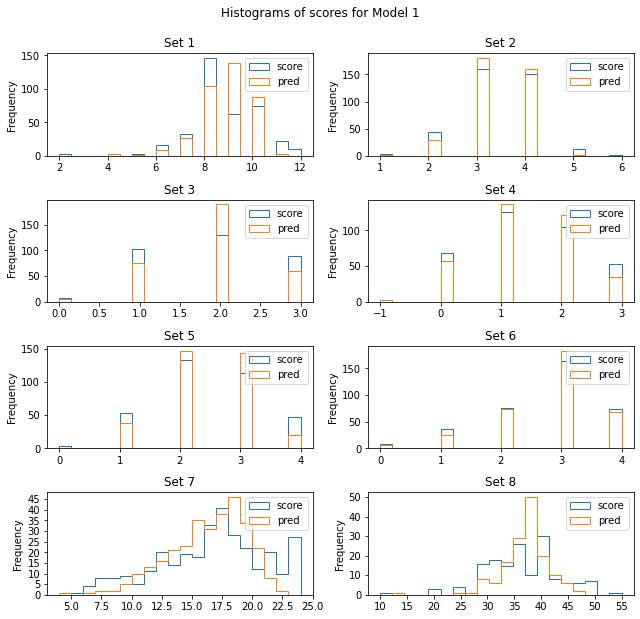

In [ ]:
plot_results(results_df, 1)

### Model 2

In [ ]:
results_df = show_results(2)

--------------------------------------
	Results for model: 2
--------------------------------------
Kappa for essay set 1:		0.7872
Kappa for essay set 2:		0.6684
Kappa for essay set 3:		0.6610
Kappa for essay set 4:		0.7548
Kappa for essay set 5:		0.8000
Kappa for essay set 6:		0.7733
Kappa for essay set 7:		0.7952
Kappa for essay set 8:		0.6646
mean QWK:			0.7380


In [ ]:
results_df.head()

,essay_id,essay_set,essay,rater1,rater2,scaled_score,scaled_pred,score,pred
0,5,1,"Dear @LOCATION1, I know having computers has a...",4,4,-0.343483,0.332592,8,9
1,1162,1,"Dear Local @CAPS1 Newspaper, @CAPS2 I see why ...",4,4,-0.343483,0.202390,8,9
2,1154,1,"Dear Readers, I understand that some @MONTH1 t...",4,4,-0.343483,-0.842760,8,7
3,1148,1,"Dear @CAPS1, @CAPS2 you probably have seen the...",5,4,0.306655,0.239678,9,9
4,1147,1,"Dear @ORGANIZATION1 staff, Are computers helpf...",4,5,0.306655,0.726961,9,10


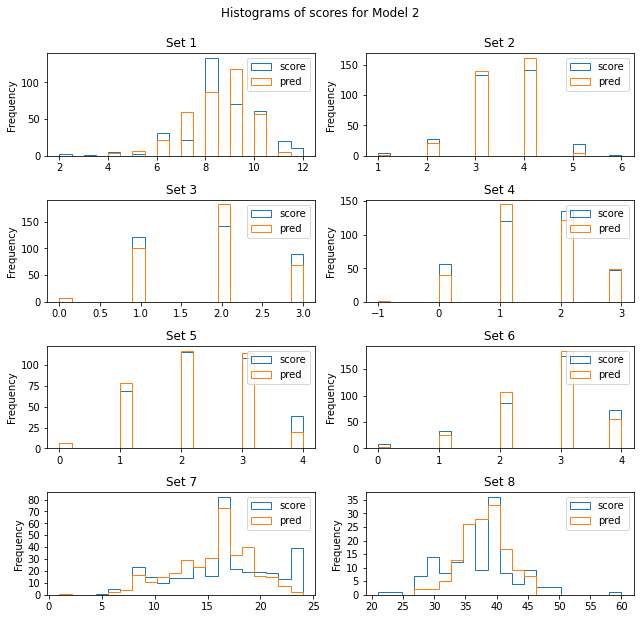

In [ ]:
plot_results(results_df, 2)

### Model 3

In [ ]:
results_df = show_results(3)

--------------------------------------
	Results for model: 3
--------------------------------------
Kappa for essay set 1:		0.7846
Kappa for essay set 2:		0.6812
Kappa for essay set 3:		0.6385
Kappa for essay set 4:		0.7905
Kappa for essay set 5:		0.7665
Kappa for essay set 6:		0.7769
Kappa for essay set 7:		0.7821
Kappa for essay set 8:		0.4753
mean QWK:			0.7120


In [ ]:
results_df.head()

,essay_id,essay_set,essay,rater1,rater2,scaled_score,scaled_pred,score,pred
0,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,0.306655,0.493981,9,9
1,1208,1,I disaree with computers are for you becau if ...,3,4,-0.993622,-1.791037,7,6
2,1204,1,To @CAPS1 @CAPS6 @MONTH1 concern: @CAPS2 I hav...,4,5,0.306655,0.986667,9,10
3,1200,1,"Dear local newspaper, @CAPS1 it has been broug...",5,4,0.306655,0.516105,9,9
4,1199,1,Computers are helpful in everyone's life. New ...,4,4,-0.343483,-0.025611,8,8


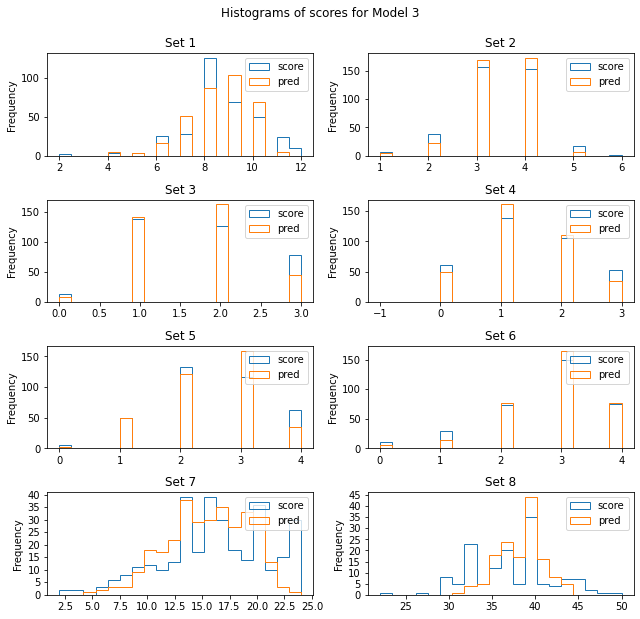

In [ ]:
plot_results(results_df, 3)

### Model 4

In [ ]:
results_df = show_results(4)

--------------------------------------
	Results for model: 4
--------------------------------------
Kappa for essay set 1:		0.7610
Kappa for essay set 2:		0.6400
Kappa for essay set 3:		0.6422
Kappa for essay set 4:		0.7980
Kappa for essay set 5:		0.7947
Kappa for essay set 6:		0.7235
Kappa for essay set 7:		0.7378
Kappa for essay set 8:		0.5502
mean QWK:			0.7059


In [ ]:
results_df.head()

,essay_id,essay_set,essay,rater1,rater2,scaled_score,scaled_pred,score,pred
0,1,1,"Dear local newspaper, I think effects computer...",4,4,-0.343483,0.050622,8,9
1,1165,1,Dear @PERSON1 @CAPS1 I am writing this letter ...,4,4,-0.343483,-0.181982,8,8
2,1164,1,"Dear @CAPS1, I am aware of the current debate ...",4,5,0.306655,1.091916,9,10
3,1163,1,"Dear Newspaper, I strongly believe that the ef...",5,5,0.956794,1.318681,10,10
4,1158,1,Dear newspaper I think that there are many rea...,4,5,0.306655,0.411474,9,9


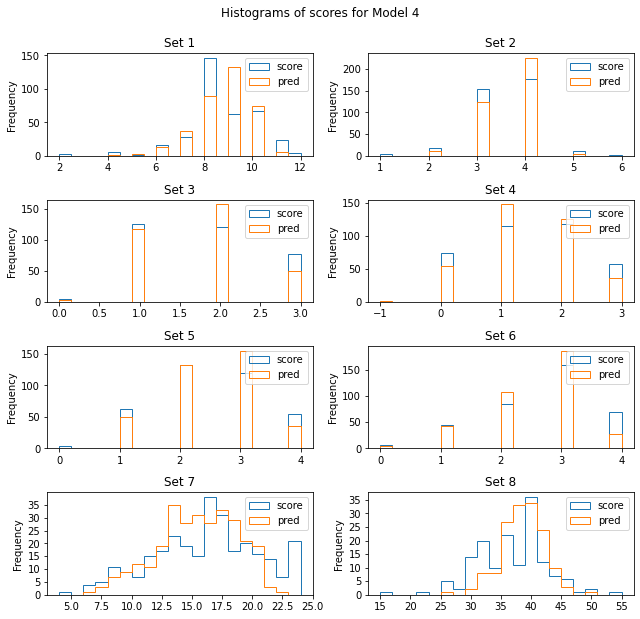

In [ ]:
plot_results(results_df, 4)

### Model 5

In [ ]:
results_df = show_results(5)

--------------------------------------
	Results for model: 5
--------------------------------------
Kappa for essay set 1:		0.7501
Kappa for essay set 2:		0.6772
Kappa for essay set 3:		0.6459
Kappa for essay set 4:		0.7249
Kappa for essay set 5:		0.7849
Kappa for essay set 6:		0.7314
Kappa for essay set 7:		0.7799
Kappa for essay set 8:		0.4986
mean QWK:			0.6991


In [ ]:
results_df.head()

,essay_id,essay_set,essay,rater1,rater2,scaled_score,scaled_pred,score,pred
0,6,1,"Dear @LOCATION1, I think that computers have a...",4,4,-0.343483,-0.342610,8,8
1,1268,1,People use computers everyday. There's so many...,4,4,-0.343483,-0.546979,8,8
2,1265,1,"Dear editors, I was planning on taking a trip ...",5,5,0.956794,0.468665,10,9
3,1261,1,Have you ever had someone move away and you wa...,4,5,0.306655,0.149345,9,9
4,1250,1,"Dear The @CAPS1 newspaper, @CAPS2 in front of ...",6,6,2.257071,1.262259,12,10


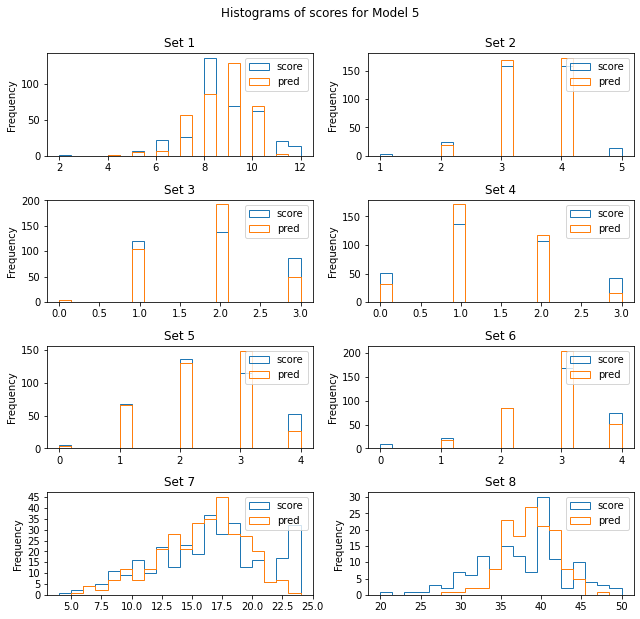

In [ ]:
plot_results(results_df, 5)